# Test Models (Base vs Few-shot vs SFT)

This notebook:
- Loads DistilGPT-2 base model
- Loads SFT checkpoint from Google Drive (`models/haiku_bot/`)
- Generates haikus for the test keywords concept family for base, few-shot, and SFT models
- Evaluates haikus for consistency, producing a plot / scoreboard

Requires:
- test_data_keywords.py from src/
- haiku_check_helpers.py from src/
- SFT checkpoint saved to Google Drive under /models/haiku_bot/


In [1]:
# install for Colab use
!pip -q install pronouncing syllables

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from test_data_keywords import particle_physics_keywords

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 35.8 MB/s eta 0:00:00


In [2]:
# need to mount google drive to access SFT model
from google.colab import drive
drive.mount('/content/drive')
SFT_MODEL_DIR = "/content/drive/MyDrive/models/haiku_bot/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if (DEVICE == "cuda") else torch.float32

Mounted at /content/drive


The haiku consistency checks are performed by the same functions used to curate the training dataset. Some additional pre-processing must take place though to handle generated haikus with any explicit line numbers or <END> lines.

In [3]:
from haiku_check_helpers import check_lines, check_syllables, check_keyword

END_TOKEN = "<END>"

def _strip_line_number_prefix(s):
    return re.sub(r"^\s*\d+\s*[\)\.\:\-]\s*", "", s).strip()

def _extract_haiku_lines_from_response(response):
    """Extract up to 3 haiku lines from a model completion.

    Handles:
      - SFT format ending with <END>
      - base-model "prompt echo" (e.g., if it repeats the instruction / '1)' placeholders)
    """

    lines = []
    for raw in response.splitlines():
        s = raw.strip()
        if not s:
            continue

        # Skip common prompt-echo lines.
        if re.match(r"^Write\s+3\s+lines\s+about\s+Keyword\s*:", s, flags=re.IGNORECASE):
            continue

        su = s.upper()
        if su == END_TOKEN:
            break

        if END_TOKEN in su:
            before = raw.split(END_TOKEN, 1)[0].strip()
            content = _strip_line_number_prefix(before)
            if content:
                lines.append(content)
            break

        content = _strip_line_number_prefix(s)
        if not content:
            # e.g. bare "1)" / "2)" / "3)" placeholders
            continue
        lines.append(content)

    return lines

def _get_keyword(prompt):
    # Search anywhere in the prompt for the keyword since few-shot prompts contain other text
    m = re.search(r"Write 3 lines about Keyword:\s*(.+?)\s*(?:\n|$)", prompt, re.IGNORECASE)
    if not m:
        raise ValueError(f"Could not extract keyword from prompt: {prompt!r}")
    return m.group(1).strip().strip("\"'")

def check_haiku(prompt, response):
    # Extract the haiku lines and its keyword based on prompt formatting
    lines = _extract_haiku_lines_from_response(response)
    keyword = _get_keyword(prompt)
    haiku = '\n'.join(lines)

    # Proceed with checks
    lines_ok, _ = check_lines(haiku)
    keyword_ok, kw_count = check_keyword(keyword, haiku)
    syllables_ok, syll_counts, line_ok = check_syllables(haiku, givelinetruth = True)
    line_ok = (line_ok + [False, False, False])[:3] # if < 3 lines, pad per-line syllable check to 3

    return {
        "lines_ok": bool(lines_ok),
        "keyword_ok": bool(keyword_ok),
        "syllables_ok": bool(syllables_ok),
        "syllables_l1_ok": bool(line_ok[0]),
        "syllables_l2_ok": bool(line_ok[1]),
        "syllables_l3_ok": bool(line_ok[2]),
        "haiku_ok": bool(lines_ok and keyword_ok and syllables_ok),
        "keyword": keyword,
        "keyword_count": int(kw_count),
        "syllable_counts": syll_counts,
        "lines": lines,
    }

Next, let's define the prompt formatting that we will pass to the models for both zero-shot and few-shot scenarios. Note that in both, we are careful to use the exact prompt/response style the SFT saw in its training data so that we can usefully and fairly evaluate both the SFT model and the base models.

In [4]:
def make_zero_shot_prompt(keyword):
    return f"Write 3 lines about Keyword: {keyword}\n1)\n2)\n3)"

def make_few_shot_prompt(keyword):
    return f"""Write a haiku about physics

    Example 1
    Write 3 lines about Keyword: force\n1)\n2)\n3)
    1) Force bends the path in
    2) Vectors pull through quiet air
    3) Motion holds its course
    <END>

    Example 2
    Write 3 lines about Keyword: energy\n1)\n2)\n3)
    1) Energy in flux
    2) Mass and motion trade their forms
    3) No loss in the sum
    <END>

    Example 3
    Write 3 lines about Keyword: symmetry\n1)\n2)\n3)
    1) Mirror laws persist
    2) Left and right agree at dawn
    3) Symmetry unchanged
    <END>

    Write 3 lines about Keyword: {keyword}\n1)\n2)\n3)
    """

With the haiku checker and prompt generators in place, let's load in the models.

In [5]:
# --- Model loading ---
set_seed(0)

from transformers.utils import logging
logging.disable_progress_bar() # progress bars don't render well in IDE / GitHub

def load_model_and_tokenizer(model_name_or_path):
    tok = AutoTokenizer.from_pretrained(model_name_or_path)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path,
        torch_dtype=DTYPE if DEVICE == "cuda" else None,
    )
    model.to(DEVICE)
    model.eval()
    return model, tok

base_model, base_tok = load_model_and_tokenizer("distilgpt2")
sft_model, sft_tok   = load_model_and_tokenizer(SFT_MODEL_DIR)

Let's build two more useful helper functions to generate and check a single haiku for a given model.

In [6]:
@torch.no_grad()
def generate_completion(model, tok, prompt: str, max_new_tokens=64, temperature=0.9, top_p=0.95):
    inputs = tok(prompt, return_tensors="pt").to(DEVICE)
    out = model.generate(
        **inputs,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=max_new_tokens,
        pad_token_id=tok.eos_token_id,
        eos_token_id=tok.eos_token_id,
    )
    gen_ids = out[0][inputs["input_ids"].shape[1]:]
    completion = tok.decode(gen_ids, skip_special_tokens=True)
    return completion

def gen_and_check(model, tok, prompt: str, **gen_kwargs):
    completion = generate_completion(model, tok, prompt, **gen_kwargs)
    result = check_haiku(prompt, completion)
    result["completion"] = completion
    return result

Finally, it's time to generate the test haikus for each model. With 25 test keywords, generating 8 haikus per keyword yields 200 test haikus. This is a reasonable number to estimate the accuracy of each model.

In [7]:
def evaluate_suite(model, tok, prompt_fn, keywords, n_per_keyword=8, **gen_kwargs):
    rows = []
    for kw in keywords:
        for _ in range(n_per_keyword):
            prompt = prompt_fn(kw)
            r = gen_and_check(model, tok, prompt, **gen_kwargs)
            rows.append({
                "keyword": kw,
                "lines_ok": r["lines_ok"],
                "keyword_ok": r["keyword_ok"],
                "syllables_ok": r["syllables_ok"],
                "syllables_l1_ok": r.get("syllables_l1_ok", False),
                "syllables_l2_ok": r.get("syllables_l2_ok", False),
                "syllables_l3_ok": r.get("syllables_l3_ok", False),
                "haiku_ok": r["haiku_ok"],
                "keyword_count": r["keyword_count"],
                "syllable_counts": r["syllable_counts"],
                "completion": r["completion"],
            })
    return pd.DataFrame(rows)

GEN_KW = dict(max_new_tokens=64, temperature=0.9, top_p=0.95)

df_base_zeroshot = evaluate_suite(base_model, base_tok, make_zero_shot_prompt, particle_physics_keywords, n_per_keyword=8, **GEN_KW)
df_base_fewshot = evaluate_suite(base_model, base_tok, make_few_shot_prompt, particle_physics_keywords, n_per_keyword=8, **GEN_KW)
df_sft_zeroshot  = evaluate_suite(sft_model,  sft_tok,  make_zero_shot_prompt, particle_physics_keywords, n_per_keyword=8, **GEN_KW)


Now let's generate a useful summary for our scorboard:

In [8]:
# --- Scoreboard ---
def summarize(df, label):
    n = len(df)
    return {
        "model": label,
        "n": n,
        "lines_ok": df["lines_ok"].mean(),
        "keyword_ok": df["keyword_ok"].mean(),
        "syllables_ok": df["syllables_ok"].mean(),
        "syllables_l1_ok": df["syllables_l1_ok"].mean(),
        "syllables_l2_ok": df["syllables_l2_ok"].mean(),
        "syllables_l3_ok": df["syllables_l3_ok"].mean(),
        "haiku_ok": df["haiku_ok"].mean(),
    }

summary = pd.DataFrame([
    summarize(df_base_zeroshot, "distilgpt2 (zero-shot)"),
    summarize(df_base_fewshot, "distilgpt2 (few-shot)"),
    summarize(df_sft_zeroshot,  "SFT model (zero-shot)"),
])

summary

,model,n,lines_ok,keyword_ok,syllables_ok,syllables_l1_ok,syllables_l2_ok,syllables_l3_ok,haiku_ok
0,distilgpt2 (zero-shot),200,0.000,0.000,0.000,0.00,0.00,0.000,0.000
1,distilgpt2 (few-shot),200,0.190,0.165,0.215,0.33,0.41,0.235,0.055
2,SFT model (zero-shot),200,0.885,0.560,0.030,0.20,0.11,0.190,0.000


To better understand the models' performances, and since each only writes 200 haikus, let's save all of the generated haikus for inspection.

In [9]:
os.makedirs("results", exist_ok=True)
summary.to_csv("results/scoreboard_summary.csv", index=False)

df_base_zeroshot.to_csv("results/test_haikus_base_zeroshot.csv", index=False)
df_base_fewshot.to_csv("results/test_haikus_base_fewshot.csv", index=False)
df_sft_zeroshot.to_csv("results/test_haikus_sft_zeroshot.csv", index=False)

Let's make a quick plot to highlight the performance of just the few-shot base and SFT models since the zero-shot model has 0 accuracy.

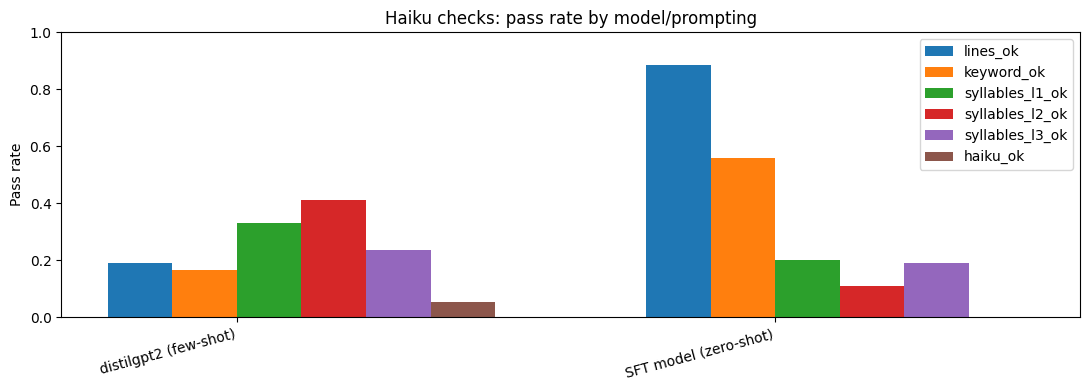

In [10]:
metrics = ["lines_ok", "keyword_ok", "syllables_l1_ok", "syllables_l2_ok", "syllables_l3_ok", "haiku_ok"]

summary_plot = summary[summary["model"] != "distilgpt2 (zero-shot)"].reset_index(drop=True)

x = np.arange(len(summary_plot["model"]))
width = 0.12

fig, ax = plt.subplots(figsize=(11, 4))

for i, m in enumerate(metrics):
    ax.bar(x + (i - 1.5)*width, summary_plot[m].values, width, label=m)

ax.set_xticks(x)
ax.set_xticklabels(summary_plot["model"], rotation=15, ha="right")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Pass rate")
ax.set_title("Haiku checks: pass rate by model/prompting")
ax.legend()

fig.tight_layout()

import os
os.makedirs("results", exist_ok=True)

fig.savefig("results/haiku_scoreboard.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()



Finally, let's take a look at some of the failure modes of each of the models.

In [11]:
def show_failures(df, title, k=5):
    print("\n===", title, "===")
    bad = df[~df["haiku_ok"]].head(k)
    for _, row in bad.iterrows():
        print(f"\nKeyword: {row['keyword']}")
        print("syllable_counts:", row["syllable_counts"], "line_ok:", [row.get("syllables_l1_ok"), row.get("syllables_l2_ok"), row.get("syllables_l3_ok")], "keyword_count:", row["keyword_count"])
        print("completion:\n", row["completion"])

show_failures(df_base_zeroshot, "distilgpt2 zero-shot failures", k=3)
show_failures(df_base_fewshot,  "distilgpt2 few-shot failures",  k=3)
show_failures(df_sft_zeroshot,  "SFT zero-shot failures",        k=3)


=== distilgpt2 zero-shot failures ===

Keyword: scalar
syllable_counts: [0] line_ok: [False, False, False] keyword_count: 0
completion:
 
4)
5)
6)
7)
8)
9)
10)
11)
12)
13)
14)
15)
16)
17)
18)
19)
20)
21)
22)
23)
24)


Keyword: scalar
syllable_counts: [0] line_ok: [False, False, False] keyword_count: 0
completion:
 
4)
5)
6)
7)
8)
9)
10)
11)
12)
13)
14)
15)
16)
17)
18)
19)
20)
21)
22)
23)
24)


Keyword: scalar
syllable_counts: [0] line_ok: [False, False, False] keyword_count: 0
completion:
 
4)
5)
6)
7)
8)
9)
10)
11)
12)
13)
14)
15)
16)
17)
18)
19)
20)
21)
22)
23)
24)


=== distilgpt2 few-shot failures ===

Keyword: scalar
syllable_counts: [5, 5, 5] line_ok: [True, False, True] keyword_count: 0
completion:
  1) Layers and a flow
    3) Layers and a flow
    3) Layers and a flow
    3) Layers and a flow
    3) Layers and a flow
   3) Layers and a flow
  

Keyword: scalar
syllable_counts: [6] line_ok: [False, False, False] keyword_count: 0
completion:
  1) Scalar curves have no change
  